# Analysis of Global Temperature Anomalies with NOAAGlobalTemp

https://www.ncei.noaa.gov/products/land-based-station/noaa-global-temp

NOAAGlobalTemp combines long-term sea surface (water) temperature (SST) and land surface (air) temperature datasets to create a complete, accurate depiction of global temperature trends. The data is available as a series of monthly temperature anomalies relative to a 1971–2000 monthly climatology (meaning we are looking at the deviation from the 1971-2000 temperature means), covering a Global 5° × 5° spatial resolution and a time frame of 1850–Present.

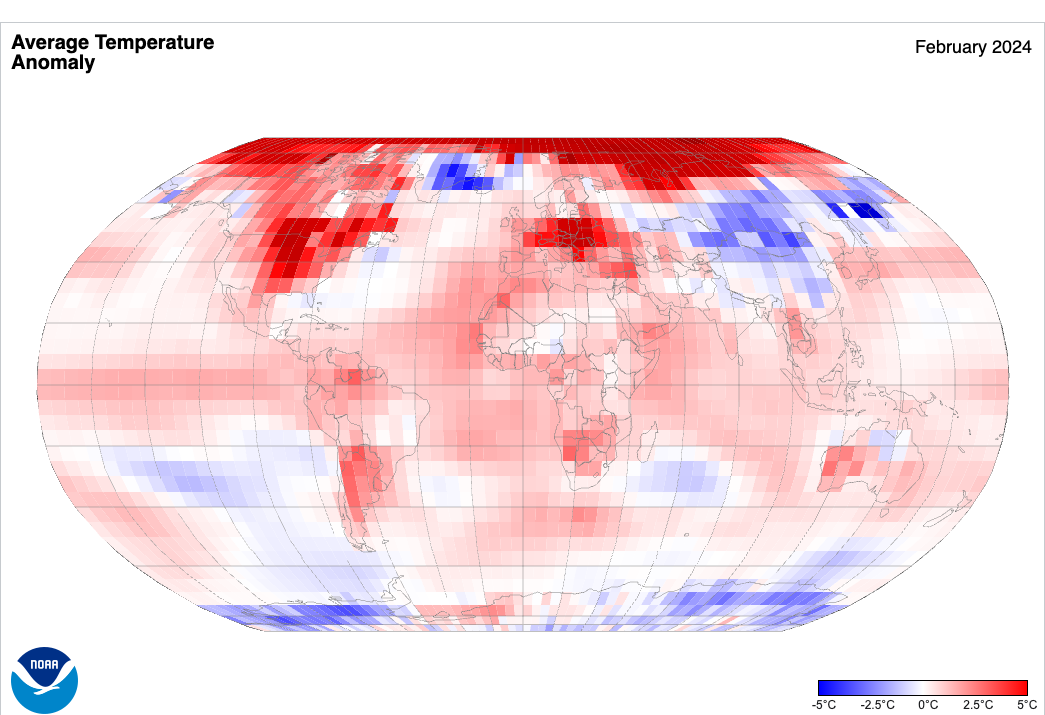

## Using the temperature anomaly data I want to see if there are any differences in regions of the globe, differences in seasonality, and creating a regression of the data

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import matplotlib.colors as mcolors
import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features 
from cartopy.util import add_cyclic_point
import scipy
from scipy import signal
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import root_mean_squared_error
import math
import seaborn as sb

In [2]:
# Open our dataset, The data is a netcdf file so we can use xarray to open it
data = xr.open_dataset('NOAAGlobalTemp_v6.0.0_gridded_s185001_e202402_c20240308T152813.nc')

In [3]:
# Take a first glance at our xarray Dataset
data

<xarray.Dataset>
Dimensions:  (time: 2090, lat: 36, lon: 72, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Data variables:
    anom     (time, z, lat, lon) float32 ...
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P174Y2M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2024-03-08T20:28:15Z
    date_issued:                     2024-03-08T20:28:15Z

In [4]:
# Check what coordinates we have. As we can see there is time in months, latitude, longitude, and z 
# (since this is surface level data there is only one value for z)
data.coords

Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0

In [5]:
# We have one variable in our dataset called 'anom', which is our temperature anomalies.
data.variables

Frozen({'time': <xarray.IndexVariable 'time' (time: 2090)>
array(['1850-01-01T00:00:00.000000000', '1850-02-01T00:00:00.000000000',
       '1850-03-01T00:00:00.000000000', ..., '2023-12-01T00:00:00.000000000',
       '2024-01-01T00:00:00.000000000', '2024-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:              reference time of global temperature anomalies
    standard_name:          time
    coverage_content_type:  coordinate
    axis:                   T, 'lat': <xarray.IndexVariable 'lat' (lat: 36)>
array([-87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5, -47.5, -42.5,
       -37.5, -32.5, -27.5, -22.5, -17.5, -12.5,  -7.5,  -2.5,   2.5,   7.5,
        12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,  47.5,  52.5,  57.5,
        62.5,  67.5,  72.5,  77.5,  82.5,  87.5], dtype=float32)
Attributes:
    long_name:              Latitude
    standard_name:          latitude
    coverage_content_type:  coordinate
    units:                  d

In [6]:
# Checking the dimensions of our temperature anomaly variable
data['anom'].dims

('time', 'z', 'lat', 'lon')

In [7]:
# Our latitudes range from -87.5 to 87.5 in degrees north in 5 degree increments
data['lat'].attrs

{'long_name': 'Latitude',
 'standard_name': 'latitude',
 'coverage_content_type': 'coordinate',
 'units': 'degrees_north',
 'grids': 'Uniform grid from -87.5 to 87.5 by 5',
 'valid_min': -87.5,
 'valid_max': 87.5,
 'axis': 'Y',
 '_CoordinateAxisType': 'Lat',
 'coordinate_defines': 'center'}

In [8]:
# Our longitudes range from 2.5 to 357.5 in degrees east in 5 degree increments
data['lon'].attrs

{'long_name': 'Longitude',
 'standard_name': 'longitude',
 'coverage_content_type': 'coordinate',
 'units': 'degrees_east',
 'grids': 'Uniform grid from 2.5 to 357.5 by 5',
 'axis': 'X',
 'valid_min': 2.5,
 'valid_max': 357.5,
 '_CoordinateAxisType': 'Lon',
 'coordinate_defines': 'center'}

In [9]:
# Our temperature anomaly values are in degrees C and have a valid range from -40 to 40
data['anom'].attrs

{'long_name': 'Global Temperature Anomalies',
 'standard_name': 'surface_temperature_anomaly',
 'coverage_content_type': 'physicalMeasurement',
 'units': 'degrees C',
 'valid_min': -40.0,
 'valid_max': 40.0}

In [10]:
# Create variables for our xarray coordinates and variables
time = data['time']
print(time)
lat = data['lat']
print(lat)
lon = data['lon']
print(lon)
anom = data['anom']
print(anom)

<xarray.DataArray 'time' (time: 2090)>
array(['1850-01-01T00:00:00.000000000', '1850-02-01T00:00:00.000000000',
       '1850-03-01T00:00:00.000000000', ..., '2023-12-01T00:00:00.000000000',
       '2024-01-01T00:00:00.000000000', '2024-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
Attributes:
    long_name:              reference time of global temperature anomalies
    standard_name:          time
    coverage_content_type:  coordinate
    axis:                   T
<xarray.DataArray 'lat' (lat: 36)>
array([-87.5, -82.5, -77.5, -72.5, -67.5, -62.5, -57.5, -52.5, -47.5, -42.5,
       -37.5, -32.5, -27.5, -22.5, -17.5, -12.5,  -7.5,  -2.5,   2.5,   7.5,
        12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,  47.5,  52.5,  57.5,
        62.5,  67.5,  72.5,  77.5,  82.5,  87.5], dtype=float32)
Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
Attribu

## Lets convert our monthly data into yearly to get the bigger picture of how climate is changing

In [11]:
# Get the length of each month in days
month_length = data.time.dt.days_in_month
print(month_length)

#Create weights based on how long each month of the year is
wgts = month_length.groupby('time.year')/month_length.groupby('time.year').sum()
print(wgts)

#Calculate our new annual global temperature anomalies
averages = data['anom'].mean(dim=['lat','lon','z'])
anom_sum = (averages * wgts).groupby('time.year').sum(dim='time')

<xarray.DataArray 'days_in_month' (time: 2090)>
array([31, 28, 31, ..., 31, 31, 29])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
Attributes:
    long_name:              reference time of global temperature anomalies
    standard_name:          time
    coverage_content_type:  coordinate
    axis:                   T
<xarray.DataArray 'days_in_month' (time: 2090)>
array([0.08493151, 0.07671233, 0.08493151, ..., 0.08493151, 0.51666667,
       0.48333333])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
    year     (time) int64 1850 1850 1850 1850 1850 ... 2023 2023 2023 2024 2024


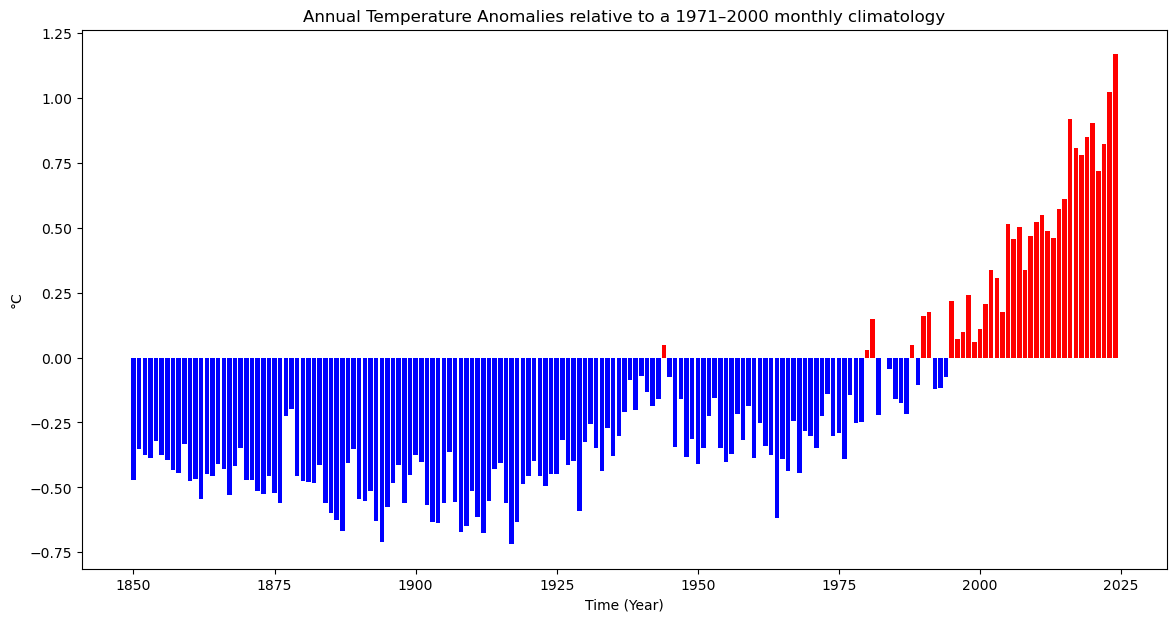

In [12]:
# Plotting our new averaged global temperature anomalies
fig, ax = plt.subplots(figsize=(14,7))
colors = np.where(anom_sum.values>0,'red','blue')
ax.bar(anom_sum['year'],anom_sum.values,color=colors)
plt.title('Annual Temperature Anomalies relative to a 1971–2000 monthly climatology')
plt.xlabel('Time (Year)')
plt.ylabel('\u00b0C')
plt.show()

## Taking a look at monthly global temperature anomalies for a recent month

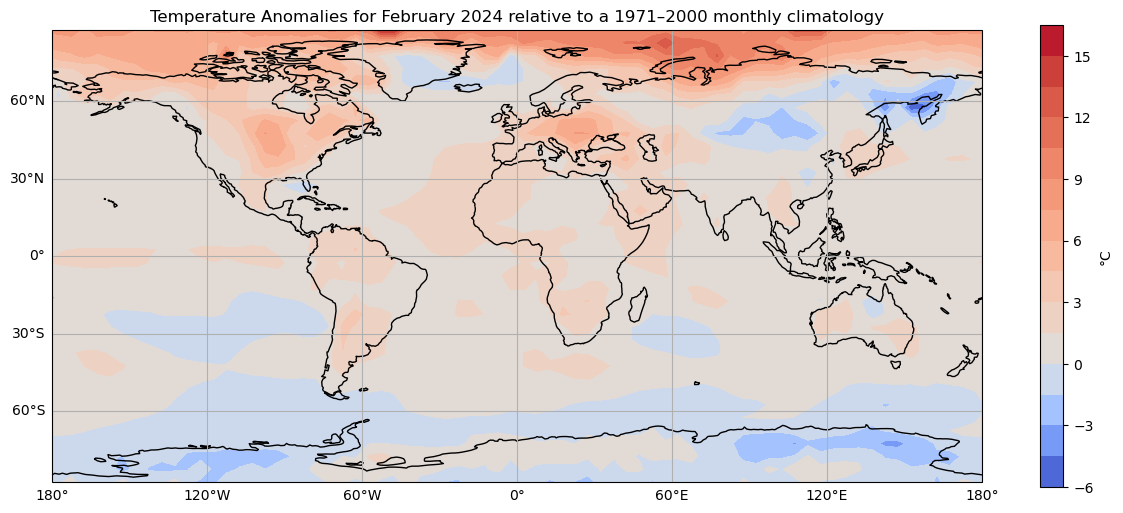

15.43


In [13]:
#Getting a colormap
cmap=plt.get_cmap('coolwarm')

# Necessary to avoid a missing strip of data
anom, lon = add_cyclic_point(anom, coord=lon)

# Create a meshgrid using lon and lat
X, Y = np.meshgrid(lon, lat)

# Get a projection
proj=ccrs.PlateCarree()

#Create a figure with an axes object on which we will plot. Pass the projection to that axes.
fig, ax = plt.subplots(figsize=(15,15),subplot_kw=dict(projection=proj))

cs = ax.contourf(X,Y,anom[-1,0,:,:],cmap=cmap,levels = 15,norm = mcolors.TwoSlopeNorm(0))
cb=fig.colorbar(cs,shrink=0.4)

# Draw gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Add coastlines
ax.coastlines()

cb.set_label("\u00b0C")
ax.set_title('Temperature Anomalies for February 2024 relative to a 1971–2000 monthly climatology')
plt.show()

print(anom[-1,0,:,:].max())

As we can see much of the world experienced warmer than average temperature anomalies. The largest being over 15 degrees C!

In fact February 2024 was the warmest February on record, according to NOAA!

https://www.ncei.noaa.gov/access/monitoring/monthly-report/global/202402

## Lets calculate our anomalies relative to 1901-2000 climatology so we can compare to the mean climate of the 20th Century
To do this we can calculate the average of the NOAAGlobalTemp anomalies for our time period (e.g. 1901–2000), and then subtract the average from the original anomalies.

In [14]:
#Calculate anomalies relative to a 1901-2000 climatology
daterange = data.sel(time=slice('1901-01-01', '2000-12-31'))
print(daterange.mean(dim='time'))
newclim = data - daterange.mean(dim='time')
newclim

<xarray.Dataset>
Dimensions:  (lat: 36, lon: 72, z: 1)
Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Data variables:
    anom     (z, lat, lon) float32 -0.1718 -0.1518 -0.1457 ... -0.3941 -0.425


<xarray.Dataset>
Dimensions:  (time: 2090, lat: 36, lon: 72, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Data variables:
    anom     (time, z, lat, lon) float32 -0.8065 -1.168 0.5559 ... 10.3 10.63

In [15]:
#Take weights to account for latitudes
weights = np.cos(np.deg2rad(data.lat))
weights.name = 'weights'
weights

<xarray.DataArray 'weights' (lat: 36)>
array([0.04361945, 0.13052624, 0.21643965, 0.30070582, 0.38268346,
       0.4617486 , 0.5372996 , 0.6087614 , 0.67559016, 0.7372773 ,
       0.7933533 , 0.8433914 , 0.8870108 , 0.9238795 , 0.95371693,
       0.976296  , 0.9914449 , 0.99904823, 0.99904823, 0.9914449 ,
       0.976296  , 0.95371693, 0.9238795 , 0.8870108 , 0.8433914 ,
       0.7933533 , 0.7372773 , 0.67559016, 0.6087614 , 0.5372996 ,
       0.4617486 , 0.38268346, 0.30070582, 0.21643965, 0.13052624,
       0.04361945], dtype=float32)
Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
Attributes:
    long_name:              Latitude
    standard_name:          latitude
    coverage_content_type:  coordinate
    units:                  degrees_north
    grids:                  Uniform grid from -87.5 to 87.5 by 5
    valid_min:              -87.5
    valid_max:              87.5
    axis:                   Y
    _CoordinateAxisType:    Lat
    coordinate_defines:     center

In [16]:
#Calculate new anomalies with latitude weights and group by year
anom_weighted = newclim.weighted(weights)
anom2 = anom_weighted.mean(dim='z')
averages2 = anom_weighted.mean(dim=['lat','lon','z'])
anom_sum2 = (averages2 * wgts).groupby('time.year').sum(dim='time')
anom_sum2

<xarray.Dataset>
Dimensions:  (year: 175)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2020 2021 2022 2023 2024
Data variables:
    anom     (year) float64 -0.1914 -0.08721 -0.04985 ... 0.8961 1.187 1.319

## Now that we have our temperature anomalies relative to the 20th century climatology lets look at the distribution of the monthly data 

In [17]:
mu, std=stats.norm.fit(averages2['anom'])
alpha, loc, beta=stats.gamma.fit(averages2['anom'])

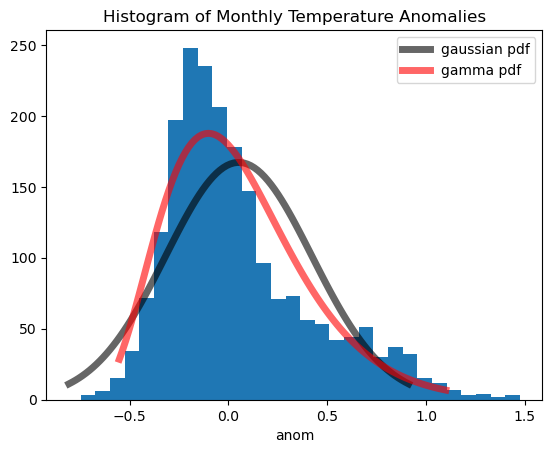

In [18]:
fig, ax = plt.subplots()
averages2['anom'].plot.hist(bins=30)
bin_width = (averages2['anom'].max()-averages2['anom'].min())/30
ax.set_title('Histogram of Monthly Temperature Anomalies')

x = np.linspace(stats.norm.ppf(0.01,mu,std),
               stats.norm.ppf(0.99,mu,std), 100)
ax.plot(x, bin_width.values*len(averages2['anom'].values.flatten())*stats.norm.pdf(x,mu,std),
          'k-', lw=5, alpha=0.6, label='gaussian pdf')

x = np.linspace(stats.gamma.ppf(0.01, alpha,loc,beta),
               stats.gamma.ppf(0.99, alpha,loc,beta), 100)
ax.plot(x, bin_width.values*len(averages2['anom'].values.flatten())*stats.gamma.pdf(x,alpha,loc,beta),
          'r-', lw=5, alpha=0.6, label='gamma pdf')

ax.legend()
plt.show()

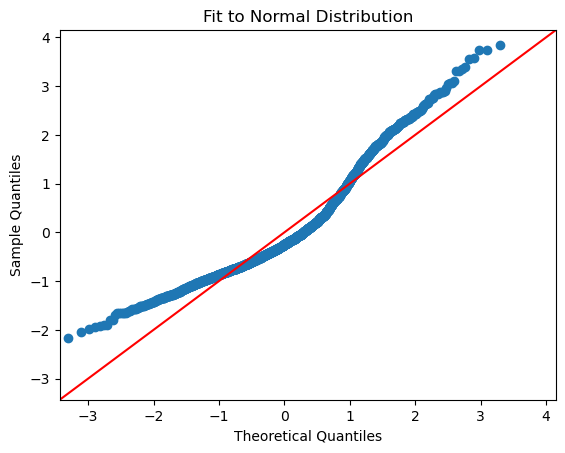

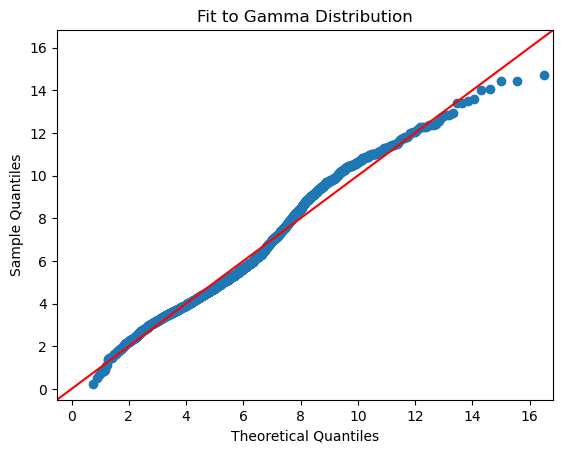

In [19]:
sm.qqplot(averages2['anom'].values.flatten(),fit=True,dist=stats.norm,line = '45')
plt.title('Fit to Normal Distribution')
plt.show()

sm.qqplot(averages2['anom'].values.flatten(),fit=True,dist=stats.gamma,line = '45')
plt.title('Fit to Gamma Distribution')
plt.show()

### The data seems to fit closer to a gamma distribution than a normal distribution. This is because of the long tail of positive anomalies i.e. the distribution is skewed toward the positive end.

## Lets look at the data again but this time in a Box and Whisker Plot

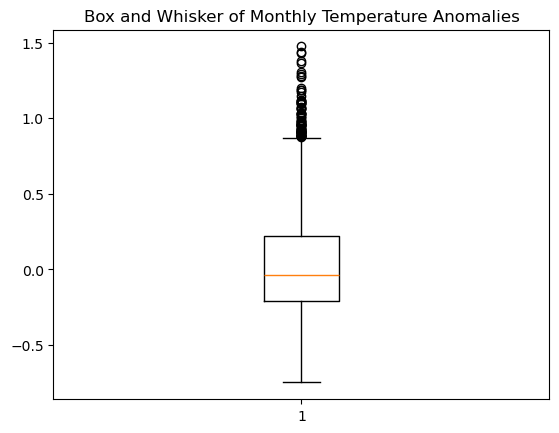

In [20]:
fig, ax = plt.subplots()
plt.boxplot(averages2['anom'].values.flatten())
ax.set_title('Box and Whisker of Monthly Temperature Anomalies')
plt.show()

### As we can see there are a large amount of positive outliers

## Looking at the data as a time-series

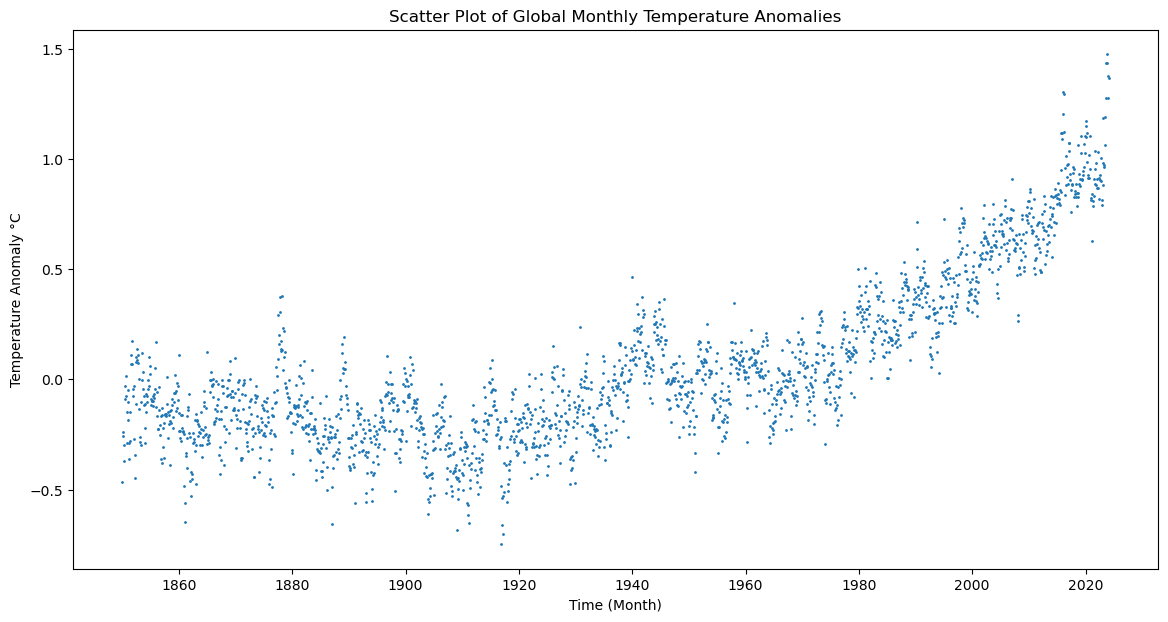

In [21]:
fig, ax = plt.subplots(figsize=(14,7))
ax.scatter(averages2['time'],averages2['anom'],s=1)
ax.set_title('Scatter Plot of Global Monthly Temperature Anomalies')
ax.set_xlabel('Time (Month)')
ax.set_ylabel('Temperature Anomaly \u00b0C')
plt.show()

### Looking at the scatter plot there seems to be an upward trend especially in more recent years since the 1960s

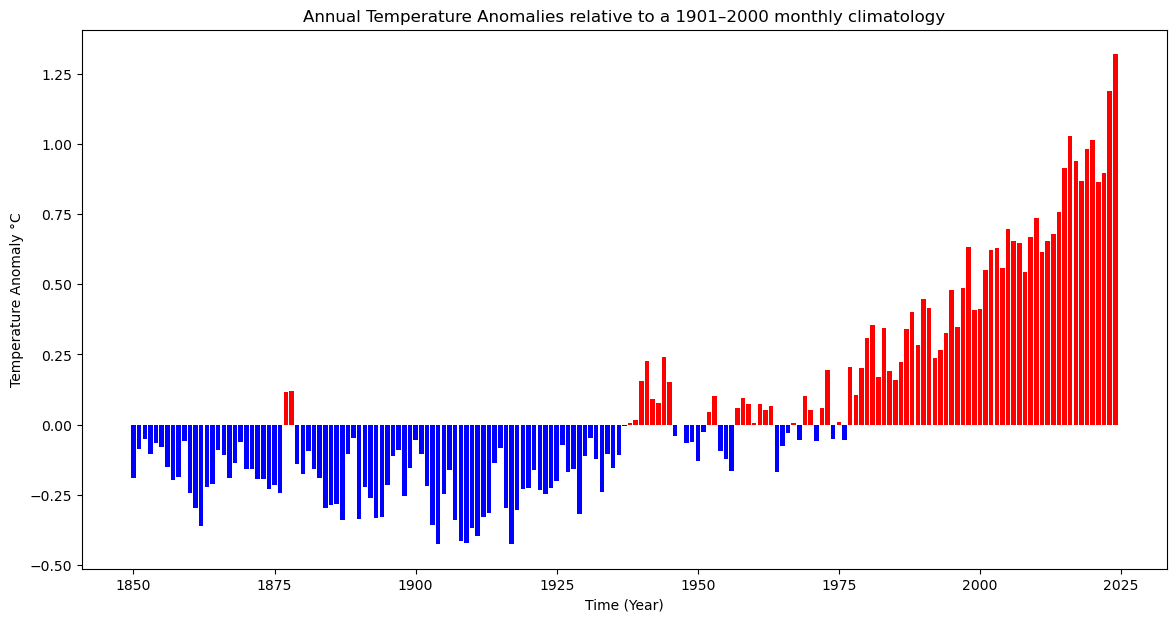

In [22]:
# Plot the annual temperature anomalies with the new climatology
fig, ax = plt.subplots(figsize=(14,7))
colors = np.where(anom_sum2['anom']>0,'red','blue')
ax.bar(anom_sum2['year'],anom_sum2['anom'].values,color=colors)
plt.title('Annual Temperature Anomalies relative to a 1901–2000 monthly climatology')
ax.set_xlabel('Time (Year)')
ax.set_ylabel('Temperature Anomaly \u00b0C')
plt.show()

## The data is extremely noisy due to it being global and monthly data so using smoothing techniques here gives us a better picture of the overall trend

Here I am using two smoothing techniques, Savitzky-Golay smoothing and Moving Window Average. For the smoothing window on both I used 30 years (360 months) since 30 years is the baseline for calculating Climate Normals. The 30-year time period was chosen by the governing body of international meteorology in the 1930s and is the current standard of the World Meteorological Organization (WMO). It provides a baseline that allows us to compare a location’s current weather to the average weather that location would expect to see

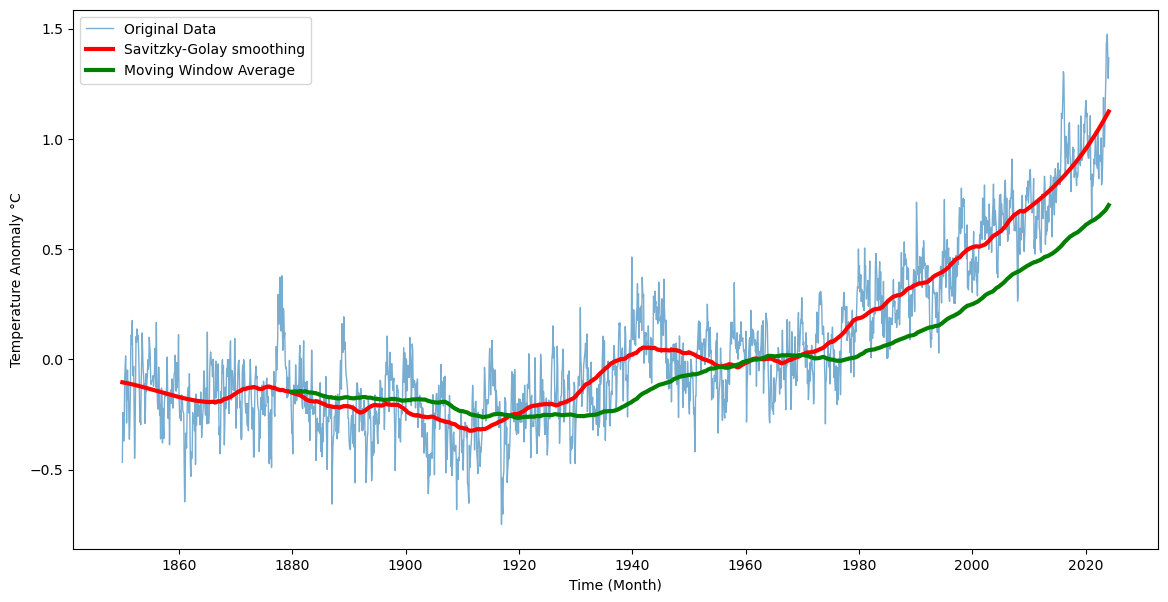

In [23]:
#Data smoothing using Savitzky-Golay filter
smootheddata = signal.savgol_filter(averages2['anom'],360,3)
#Data smoothing using Moving Windows Average
rolling = averages2.rolling(time=360).mean()

#Plot our origingal data against the two smoothing techniques
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(averages2['time'],averages2['anom'],alpha=0.6,linewidth=1,label='Original Data')
ax.plot(averages2['time'],smootheddata,'r',linewidth=3,label='Savitzky-Golay smoothing')
ax.plot(averages2['time'],rolling['anom'],'g',linewidth=3,label='Moving Window Average')
ax.set_xlabel('Time (Month)')
ax.set_ylabel('Temperature Anomaly \u00b0C')
ax.legend()
plt.show()

### The Savitzky-Golay smoothing looks to be closer fit to the original data than the moving window average

## Looking at temperature anomalies over different regions
### Here I am interested in seeing if there is a relationship with latitude and temperature anomalies. We know latitude greatly impacts temperature but how does it affect anomalies?
First I split my data into 6 latitude bands, each one 30 degrees, over all longitudes starting from 90 degrees north to -90 degrees north

In [24]:
# Use coarsen to downsample our data into 6 latitude regions
regions = newclim.coarsen(lat=6).mean()
print(regions)

# Take weights to account for latitudes
weights = np.cos(np.deg2rad(regions.lat))
weights.name = 'weights'
weights

anom_weighted = regions.weighted(weights)
regionsw = anom_weighted.mean(dim=['z'])
print(regionsw)

<xarray.Dataset>
Dimensions:  (time: 2090, z: 1, lat: 6, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
  * lat      (lat) float32 -75.0 -45.0 -15.0 15.0 45.0 75.0
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Data variables:
    anom     (time, z, lat, lon) float32 0.09924 0.1564 0.2484 ... 4.128 2.68
<xarray.Dataset>
Dimensions:  (time: 2090, lat: 6, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
  * lat      (lat) float32 -75.0 -45.0 -15.0 15.0 45.0 75.0
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Data variables:
    anom     (time, lat, lon) float32 0.09924 0.1564 0.2484 ... 4.232 4.128 2.68


Now our data has 6 latitude values represented the 6 30 degree latitude bands

In [25]:
# Calculate annual anomalies over the latitude bands
regionsyear = (regionsw * wgts).groupby('time.year').sum(dim='time')
regionsyear = regionsyear.mean(dim='lon')
regionsyear = regionsyear.drop_sel(year=2024)

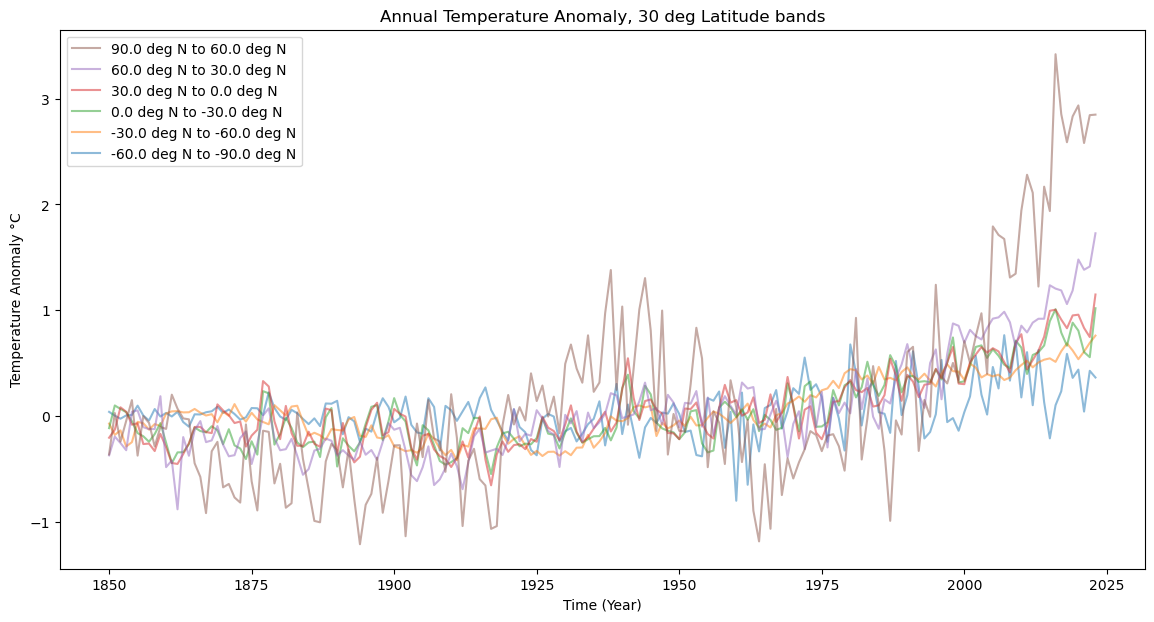

In [26]:
# Plot the bands against each other
fig, ax = plt.subplots(figsize=(14, 7))
for lat in regionsyear['lat']:
    val = regionsyear.sel(lat=lat)
    ax.plot(val['year'], val['anom'], alpha=0.5, label=str(lat.values+15)+' deg N to '+str(lat.values-15)+' deg N')
ax.legend(loc='upper left',reverse=True)
ax.set_title('Annual Temperature Anomaly, 30 deg Latitude bands')
ax.set_xlabel('Time (Year)')
ax.set_ylabel('Temperature Anomaly \u00b0C')
plt.show()

## The northern most band from 90 degrees N to 60 degrees N is experiencing anomaly values over double that of some of the other regions in the past few decades!

### Lets explore the data further by looking at a Box and Whisker Plot

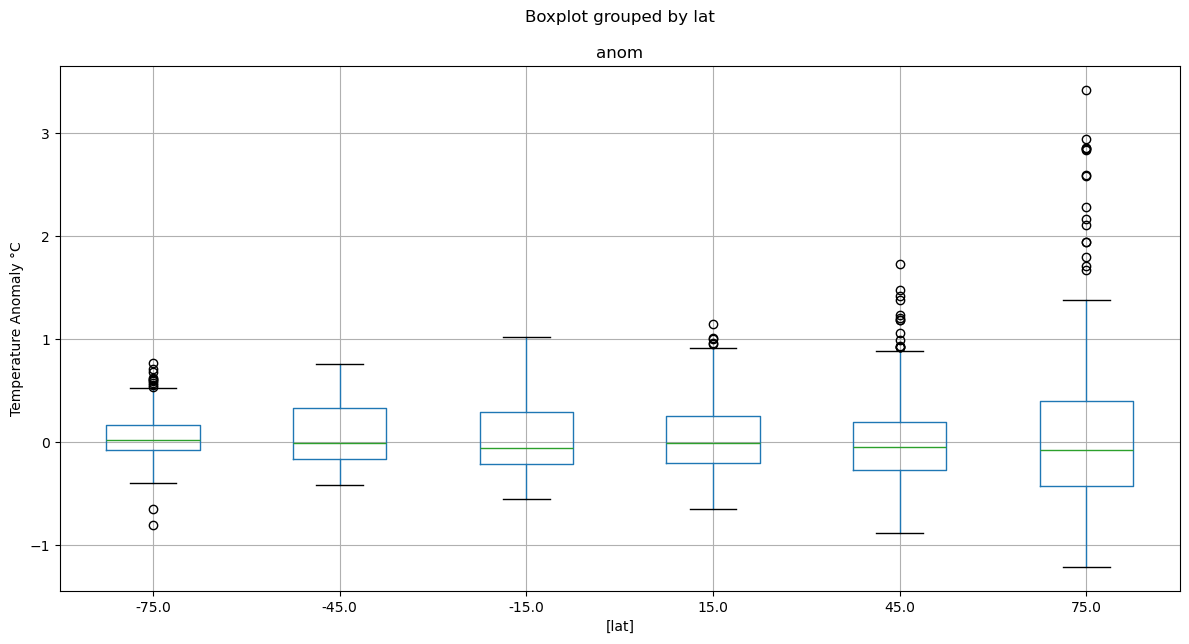

In [27]:
# Create Box Plots of our latitude bands
fig, ax = plt.subplots(figsize=(14, 7))
df = regionsyear.to_dataframe()
df.boxplot(ax=ax, by='lat')
ax.set_ylabel('Temperature Anomaly \u00b0C')
plt.show()

## Our northern latitude band is approximately where the Arctic Circle is located, above 67 degrees N. So lets use a hypothesis test to see if the Arctic Circle is warming faster than the rest of the world.

In [28]:
# Split data into Arctic Circle and outside of the Arctic Circle
arccir = anom2.where(anom2.lat >= 67,drop=True)
non_arccir = anom2.where(anom2.lat < 67,drop=True)
print(arccir)
print(non_arccir)

<xarray.Dataset>
Dimensions:  (time: 2090, lat: 5, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
  * lat      (lat) float32 67.5 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Data variables:
    anom     (time, lat, lon) float32 -1.114 -1.102 -2.768 ... 10.49 10.3 10.63
<xarray.Dataset>
Dimensions:  (time: 2090, lat: 31, lon: 72)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-02-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 47.5 52.5 57.5 62.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
Data variables:
    anom     (time, lat, lon) float32 -0.8065 -1.168 0.5559 ... 1.02 1.069


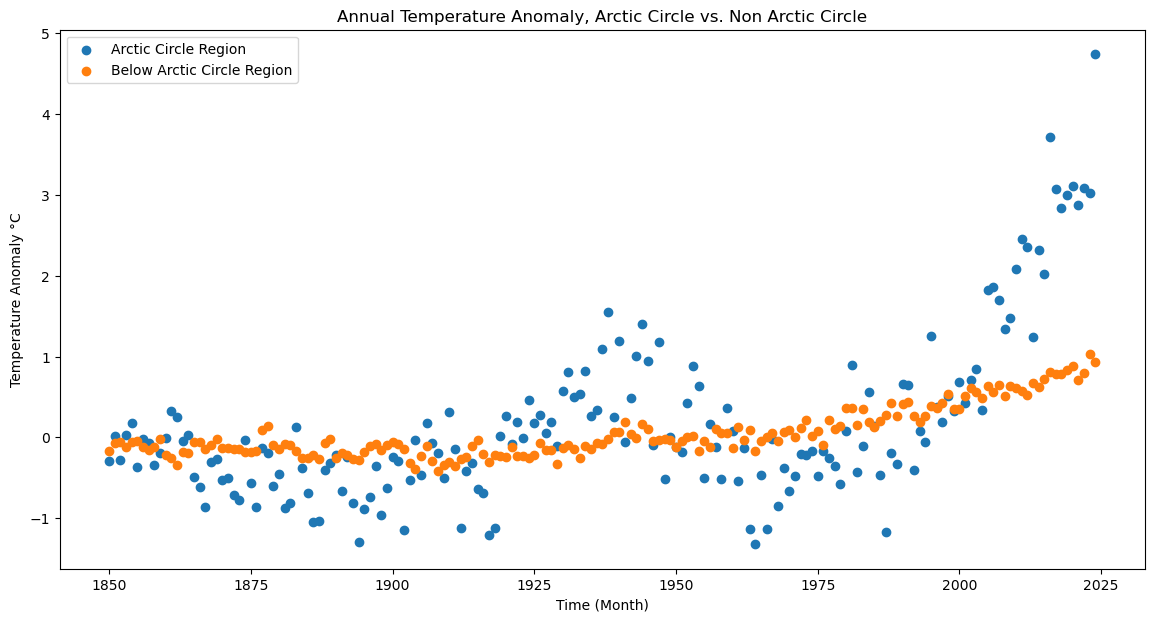

In [29]:
# Calculate annual anomalies for our two groups
arccir_ann = (arccir * wgts).groupby('time.year').sum(dim='time')
arccir_ann = arccir_ann.mean(dim=['lat','lon'])
non_arccir_ann = (non_arccir * wgts).groupby('time.year').sum(dim='time')
non_arccir_ann = non_arccir_ann.mean(dim=['lat','lon'])

#Create a scatter plot of Annual Temperature Anomaly, Arctic Circle vs. Non Arctic Circle
fig, ax = plt.subplots(figsize=(14,7))
ax.scatter(arccir_ann['year'],arccir_ann['anom'],label='Arctic Circle Region')
ax.scatter(non_arccir_ann['year'],non_arccir_ann['anom'],label='Below Arctic Circle Region')
ax.legend()
ax.set_title('Annual Temperature Anomaly, Arctic Circle vs. Non Arctic Circle')
ax.set_xlabel('Time (Month)')
ax.set_ylabel('Temperature Anomaly \u00b0C')
plt.show()

## Now lets check the distributions of our two groups

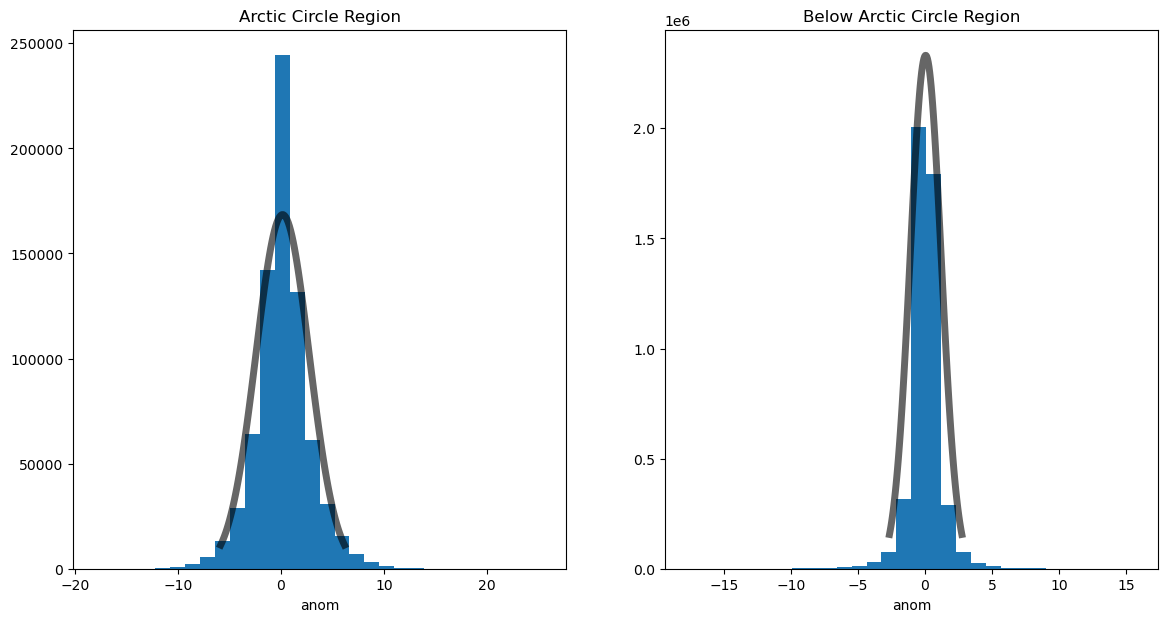

In [30]:
# Plot the histogram
fig,ax = plt.subplots(1,2,figsize=(14,7))
bin_width = (arccir['anom'].max()-arccir['anom'].min())/30
arccir['anom'].plot.hist(ax=ax[0], bins=30)
ax[0].set_title('Arctic Circle Region')

# Fit a normal distribution and plot it
mu, std=stats.norm.fit(arccir['anom'])
x = np.linspace(stats.norm.ppf(0.01,mu,std),
               stats.norm.ppf(0.99,mu,std), 100)

# Plot the normal distribution with the parameters we estimated from our data 
ax[0].plot(x, bin_width.values*len(arccir['anom'].values.flatten())*stats.norm.pdf(x,mu,std),
          'k-', lw=5, alpha=0.6, label='gaussian pdf')

# Plot the histogram
bin_width = (arccir['anom'].max()-arccir['anom'].min())/30
non_arccir['anom'].plot.hist(ax=ax[1], bins=30)
ax[1].set_title('Below Arctic Circle Region')

# Fit a normal distribution and plot it
mu, std=stats.norm.fit(non_arccir['anom'])
x = np.linspace(stats.norm.ppf(0.01,mu,std),
               stats.norm.ppf(0.99,mu,std), 100)

# Plot the normal distribution with the parameters we estimated from our data 
ax[1].plot(x, bin_width.values*len(non_arccir['anom'].values.flatten())*stats.norm.pdf(x,mu,std),
          'k-', lw=5, alpha=0.6, label='gaussian pdf')
plt.show()

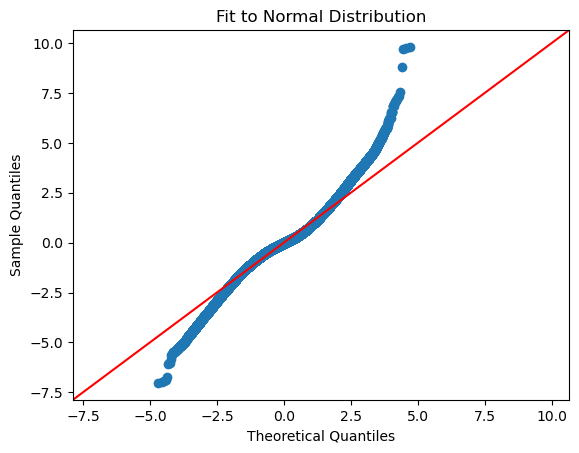

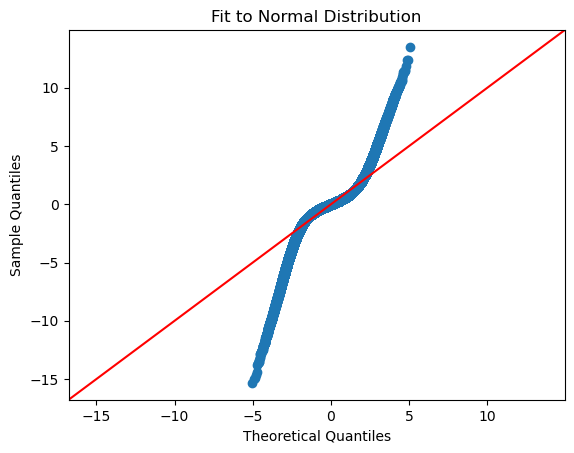

In [31]:
# Quantile-quantile plots
sm.qqplot(arccir['anom'].values.flatten(),fit=True,dist=stats.norm,line = '45')
plt.title('Fit to Normal Distribution')
plt.show()

sm.qqplot(non_arccir['anom'].values.flatten(),fit=True,dist=stats.norm,line = '45')
plt.title('Fit to Normal Distribution')
plt.show()

## Our two regions are not a great fit with a normal distribution so can use Mann Whitney Test for the hypothesis tests

In [32]:
# This first test is looking that the distributions different, as represented by their medians.
two_side = stats.mannwhitneyu(x=non_arccir['anom'].values.flatten(), y=arccir['anom'].values.flatten(), alternative = 'two-sided')
print(two_side)
# The p value is well below 0.05 so we can reject the null hypothesis and favor the alternate, that the distributions are different

# Is the non arctic circle distribution is less than the arctic circle region?
one_side = stats.mannwhitneyu(x=non_arccir['anom'].values.flatten(), y=arccir['anom'].values.flatten(), alternative = 'less')
print(one_side)
# The p value is well below 0.05 so we can reject the null hypothesis and favor the alternate, that the non arctic circle distribution is less than the arctic circle region



MannwhitneyuResult(statistic=1719300040381.5, pvalue=3.1044683654675946e-176)
MannwhitneyuResult(statistic=1719300040381.5, pvalue=1.5522341827337973e-176)


### For the two-sided and one-sided tests the null hypotheses are rejected in both cases, which indicates that the Arctic Region is differently distributed than the rest of the world, and is warming at a faster rate.

This is due to a phenomenon known as Arctic Amplification!

https://climate.nasa.gov/news/927/arctic-amplification/

## Now lets do similar hypothesis tests but looking at meterological seasons Winter, Spring, Summer, and Fall

Here I use resample to downsample my data into seasons

In [33]:
anom_seasons = anom2.resample(time='QE-FEB').mean(dim='time')
anom_seasons

<xarray.Dataset>
Dimensions:  (lat: 36, lon: 72, time: 697)
Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * time     (time) datetime64[ns] 1850-02-28 1850-05-31 ... 2024-02-29
Data variables:
    anom     (time, lat, lon) float32 -0.3458 -0.8328 0.4311 ... 7.923 8.028

### Next we need to account for the seasonality in the hemispheres being reversed. I also want to look at regions most affected by seasonality so I am selected data in the North and South Temperate Zones, approximately 23.5 to 66.5 degrees N and -66.5 to -23.5 degrees N.

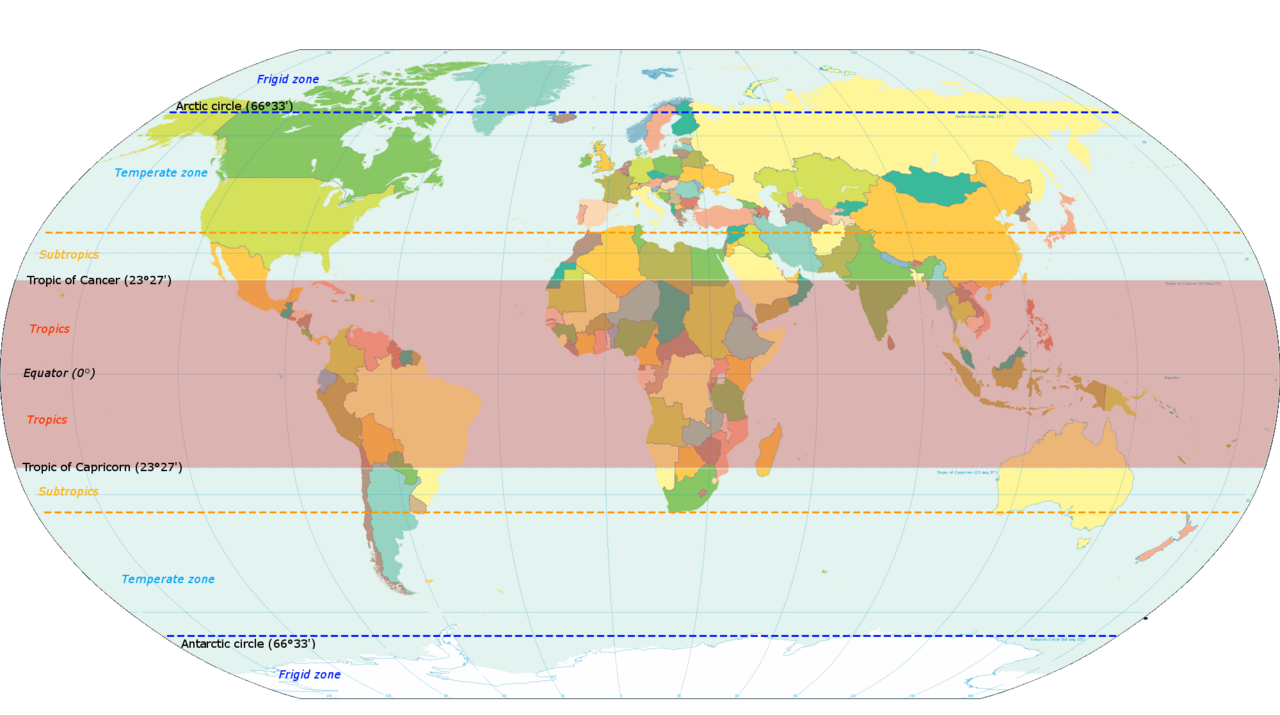

In [34]:
# Create variables for northern and southern zones for each quarter
anom_djf_n = anom_seasons.sel(time=anom_seasons['time.season']=='DJF', lat=slice(23.5,66.5))
anom_djf_s = anom_seasons.sel(time=anom_seasons['time.season']=='DJF', lat=slice(-66.5,-23.5))
anom_mam_n = anom_seasons.sel(time=anom_seasons['time.season']=='MAM', lat=slice(23.5,66.5))
anom_mam_s = anom_seasons.sel(time=anom_seasons['time.season']=='MAM', lat=slice(-66.5,-23.5))
anom_jja_n = anom_seasons.sel(time=anom_seasons['time.season']=='JJA', lat=slice(23.5,66.5))
anom_jja_s = anom_seasons.sel(time=anom_seasons['time.season']=='JJA', lat=slice(-66.5,-23.5))
anom_son_n = anom_seasons.sel(time=anom_seasons['time.season']=='SON', lat=slice(23.5,66.5))
anom_son_s = anom_seasons.sel(time=anom_seasons['time.season']=='SON', lat=slice(-66.5,-23.5))

# Concatenate data from north and south zones to create seasonal data
anom_win = xr.concat([anom_djf_n,anom_jja_s],dim='time')
anom_spr = xr.concat([anom_mam_n,anom_son_s],dim='time')
anom_summ = xr.concat([anom_jja_n,anom_djf_s],dim='time')
anom_fall = xr.concat([anom_son_n,anom_mam_s],dim='time')

# Take spatial averages and sort by time
anom_win = anom_win.mean(dim=['lat','lon']).sortby('time')
anom_spr = anom_spr.mean(dim=['lat','lon']).sortby('time')
anom_summ = anom_summ.mean(dim=['lat','lon']).sortby('time')
anom_fall = anom_fall.mean(dim=['lat','lon']).sortby('time')

# Drop 2024 data
anom_win = anom_win.drop_sel(time='2024-02-29')
anom_summ = anom_summ.drop_sel(time='2024-02-29')

# Calculate annual anomaly values
anom_win_ann = anom_win.groupby('time.year').mean(dim='time')
anom_spr_ann = anom_spr.groupby('time.year').mean(dim='time')
anom_summ_ann = anom_summ.groupby('time.year').mean(dim='time')
anom_fall_ann = anom_fall.groupby('time.year').mean(dim='time')

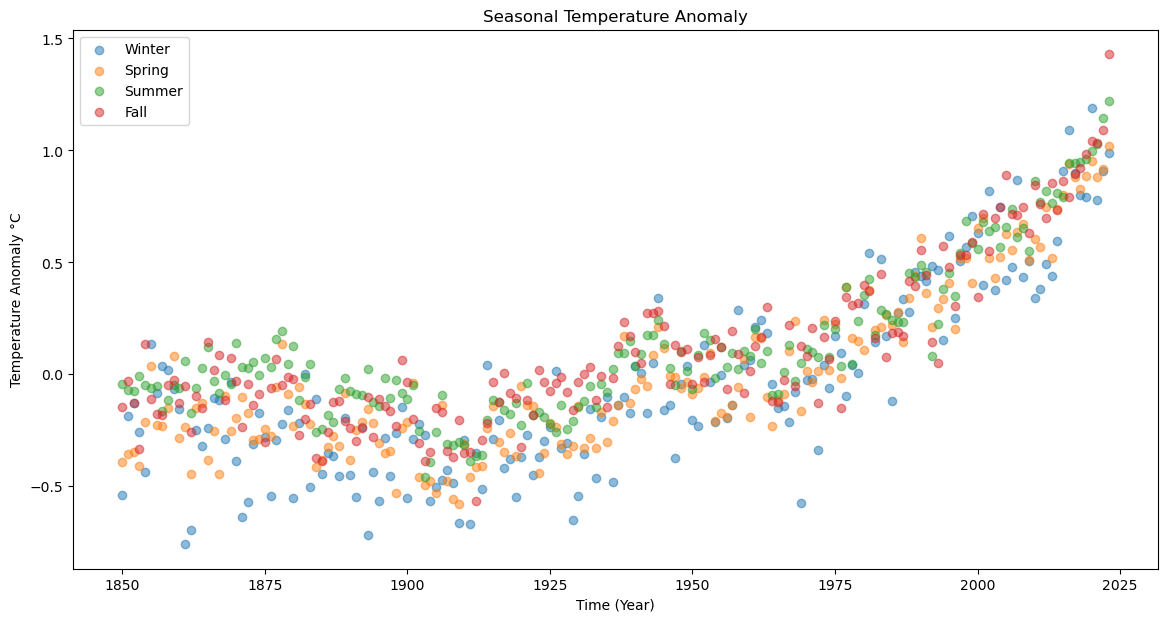

In [35]:
# Plot scatter plot of seasonal temperature anomaly
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(anom_win_ann['year'], anom_win_ann['anom'], alpha=0.5, label='Winter')
ax.scatter(anom_spr_ann['year'], anom_spr_ann['anom'], alpha=0.5, label='Spring')
ax.scatter(anom_summ_ann['year'], anom_summ_ann['anom'], alpha=0.5, label='Summer')
ax.scatter(anom_fall_ann['year'], anom_fall_ann['anom'], alpha=0.5, label='Fall')
ax.set_title('Seasonal Temperature Anomaly')
ax.set_xlabel('Time (Year)')
ax.set_ylabel('Temperature Anomaly \u00b0C')
ax.legend()
plt.show()

### Lets explore the data further by looking at a Box and Whisker Plot

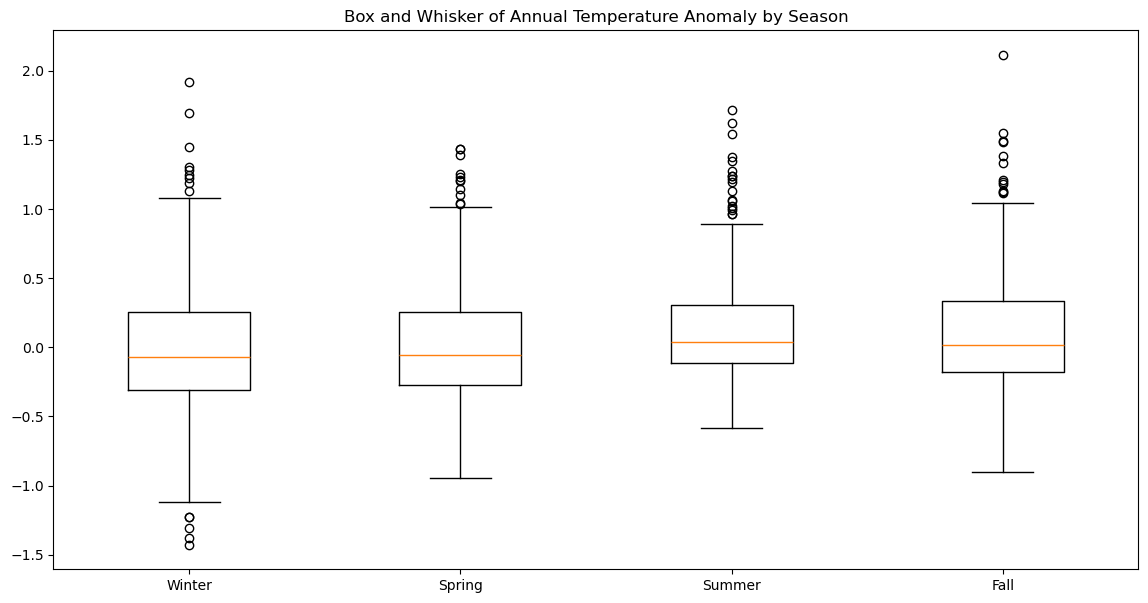

In [36]:
# Create Box and Whisker Plots 
seasons = {'Winter': anom_win['anom'].values.flatten(),'Spring': anom_spr['anom'].values.flatten(),'Summer': anom_summ['anom'].values.flatten(),'Fall': anom_fall['anom'].values.flatten()}

fig, ax = plt.subplots(figsize=(14, 7))
ax.boxplot(seasons.values())
ax.set_title('Box and Whisker of Annual Temperature Anomaly by Season')
ax.set_xticklabels(seasons.keys())
plt.show()

## Looking at our time series plots and box and whisker plots it appears that Winter experiences lower anomalies
### Now lets compare the distributions of Winter vs. Non-Winter anomalies

In [37]:
# Concatenate spring, summer, and fall datasets
anom_nonwin = xr.concat([anom_spr,anom_summ,anom_fall],dim='time')
anom_nonwin = anom_nonwin.sortby('time')
anom_nonwin

<xarray.Dataset>
Dimensions:  (time: 1044)
Coordinates:
  * time     (time) datetime64[ns] 1850-02-28 1850-05-31 ... 2023-11-30
Data variables:
    anom     (time) float32 -0.07271 -0.6519 0.006359 ... 1.716 0.6467 2.116

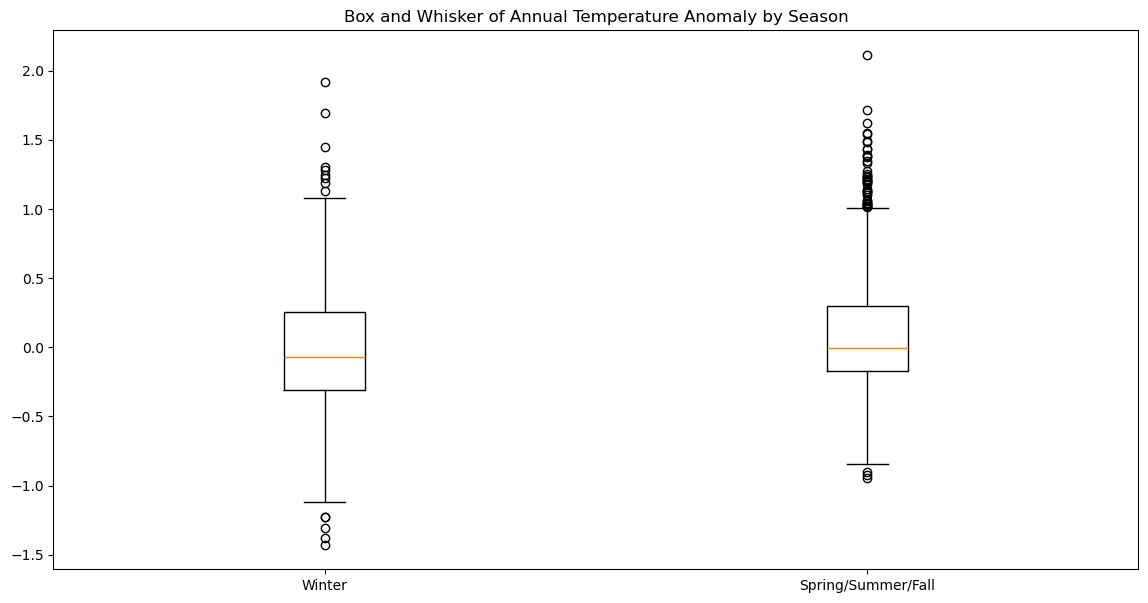

In [38]:
seasons = {'Winter': anom_win['anom'].values.flatten(),'Spring/Summer/Fall': anom_nonwin['anom'].values.flatten()}

fig, ax = plt.subplots(figsize=(14, 7))
ax.boxplot(seasons.values())
ax.set_title('Box and Whisker of Annual Temperature Anomaly by Season')
ax.set_xticklabels(seasons.keys())
plt.show()

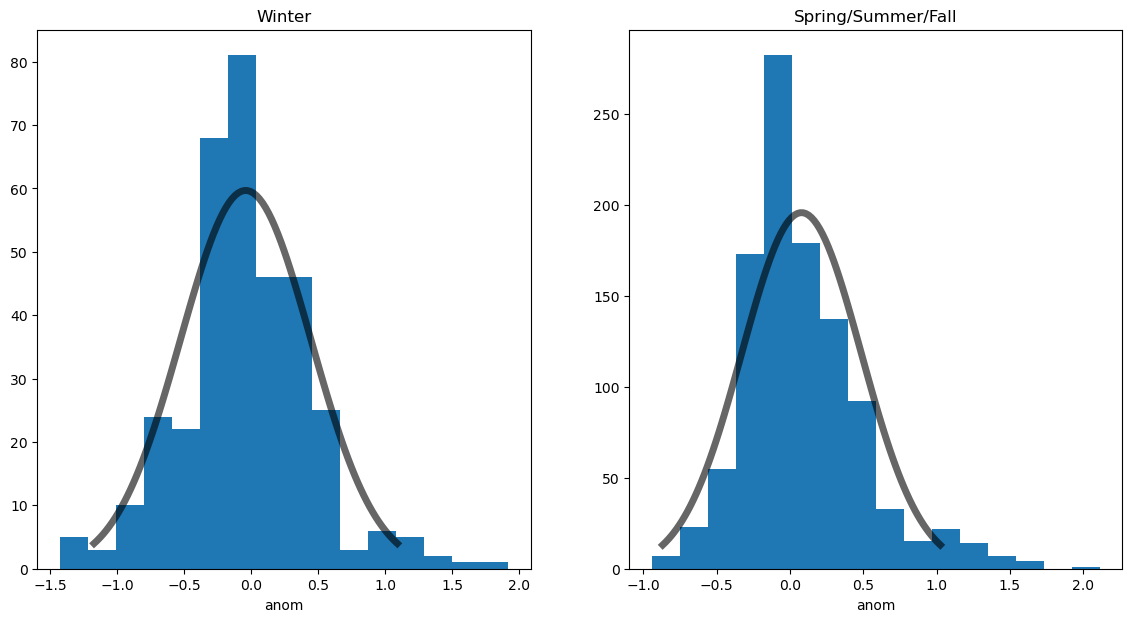

In [39]:
# Plot the histogram
fig,ax = plt.subplots(1,2,figsize=(14,7))
bin_width = (anom_win['anom'].max()-anom_win['anom'].min())/16
anom_win['anom'].plot.hist(ax=ax[0], bins=16)
ax[0].set_title('Winter')

# Fit a normal distribution and plot it
mu, std=stats.norm.fit(anom_win['anom'])
x = np.linspace(stats.norm.ppf(0.01,mu,std),
               stats.norm.ppf(0.99,mu,std), 100)

# Plot the normal distribution with the parameters we estimated from our data 
ax[0].plot(x, bin_width.values*len(anom_win['anom'])*stats.norm.pdf(x,mu,std),
          'k-', lw=5, alpha=0.6, label='gaussian pdf')

# Plot the histogram
bin_width = (anom_nonwin['anom'].max()-anom_nonwin['anom'].min())/16
anom_nonwin['anom'].plot.hist(ax=ax[1], bins=16)
ax[1].set_title('Spring/Summer/Fall')

# Fit a normal distribution and plot it
mu, std=stats.norm.fit(anom_nonwin['anom'])
x = np.linspace(stats.norm.ppf(0.01,mu,std),
               stats.norm.ppf(0.99,mu,std), 100)

# Plot the normal distribution with the parameters we estimated from our data 
ax[1].plot(x, bin_width.values*len(anom_nonwin['anom'])*stats.norm.pdf(x,mu,std),
          'k-', lw=5, alpha=0.6, label='gaussian pdf')
plt.show()

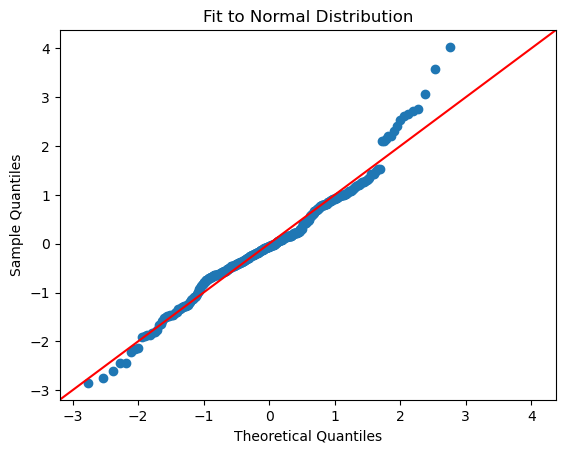

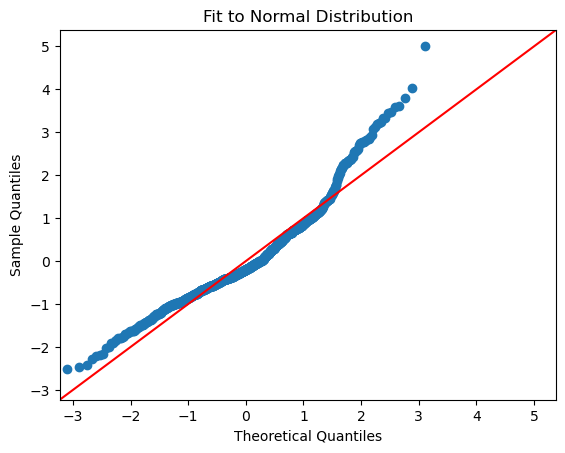

In [40]:
# Quantile-quantile plots
sm.qqplot(anom_win['anom'].values.flatten(),fit=True,dist=stats.norm,line = '45')
plt.title('Fit to Normal Distribution')
plt.show()

sm.qqplot(anom_nonwin['anom'].values.flatten(),fit=True,dist=stats.norm,line = '45')
plt.title('Fit to Normal Distribution')
plt.show()

### Our two regions are not a great fit with a normal distribution so can use Mann Whitney Test for the hypothesis tests

In [41]:
# This first test is looking that the distributions different, as represented by their medians.
two_side = stats.mannwhitneyu(x=anom_nonwin['anom'].values.flatten(), y=anom_win['anom'].values.flatten(), alternative = 'two-sided')
print(two_side)
# The p value is well below 0.05 so we can reject the null hypothesis and favor the alternate, that the distributions are different

# Is the Winter distribution is less than the rest of the year?
one_side = stats.mannwhitneyu(x=anom_nonwin['anom'].values.flatten(), y=anom_win['anom'].values.flatten(), alternative = 'greater')
print(one_side)
# The p value is well below 0.05 so we can reject the null hypothesis and favor the alternate, that the Winter distribution is less than the arctic circle region

MannwhitneyuResult(statistic=207892.0, pvalue=5.348688332037119e-05)
MannwhitneyuResult(statistic=207892.0, pvalue=2.6743441660185595e-05)


### For the two-sided and one-sided tests the null hypotheses are rejected in both cases, which indicates that the Winter season is differently distributed than the rest of the world, and is not warming at as fast a rate as the rest of the year.

## Lets try to model the monthly temperature anomaly data using Univariate Linear Regression with time as the predictor and the anomaly as the predictand

In [42]:
x = sm.add_constant(anom_sum2['year'])
y = anom_sum2['anom'].to_numpy()

mod_uni = sm.OLS(y,x).fit()

print(mod_uni)
print(mod_uni.summary())

y_pred_uni = mod_uni.fittedvalues

rmse_err_uni = root_mean_squared_error(y, y_pred_uni)
print('RMSE = ',rmse_err_uni)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     317.4
Date:                Fri, 03 May 2024   Prob (F-statistic):           5.43e-41
Time:                        21:23:08   Log-Likelihood:                 19.766
No. Observations:                 175   AIC:                            -35.53
Df Residuals:                     173   BIC:                            -29.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1656      0.630    -17.716      0.0

### Our R-squared value is 0.647 which isn't great, our RMSE is 0.216 which is quite large for our range, and our p value is 0

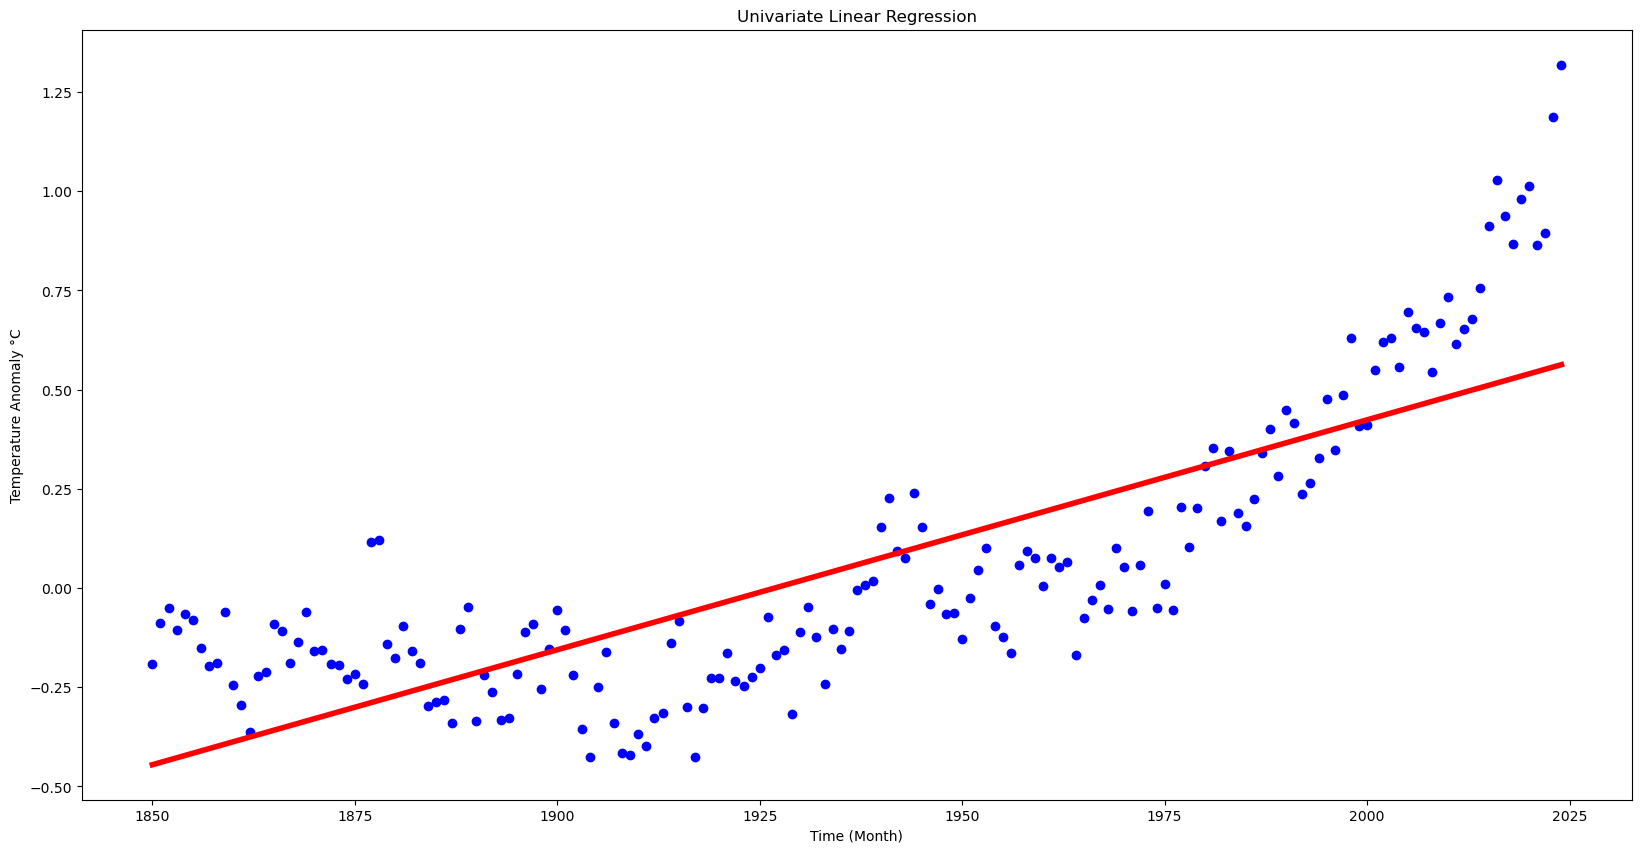

In [43]:
fig,ax=plt.subplots(figsize=(20,10))
ax.scatter(anom_sum2['year'], anom_sum2['anom'], color='blue')

ax.set_xlabel('Time (Month)')
ax.set_ylabel('Temperature Anomaly \u00b0C')
ax.set_title('Univariate Linear Regression')

ax.plot(anom_sum2['year'], y_pred_uni, color='red',linewidth=4)
plt.show()

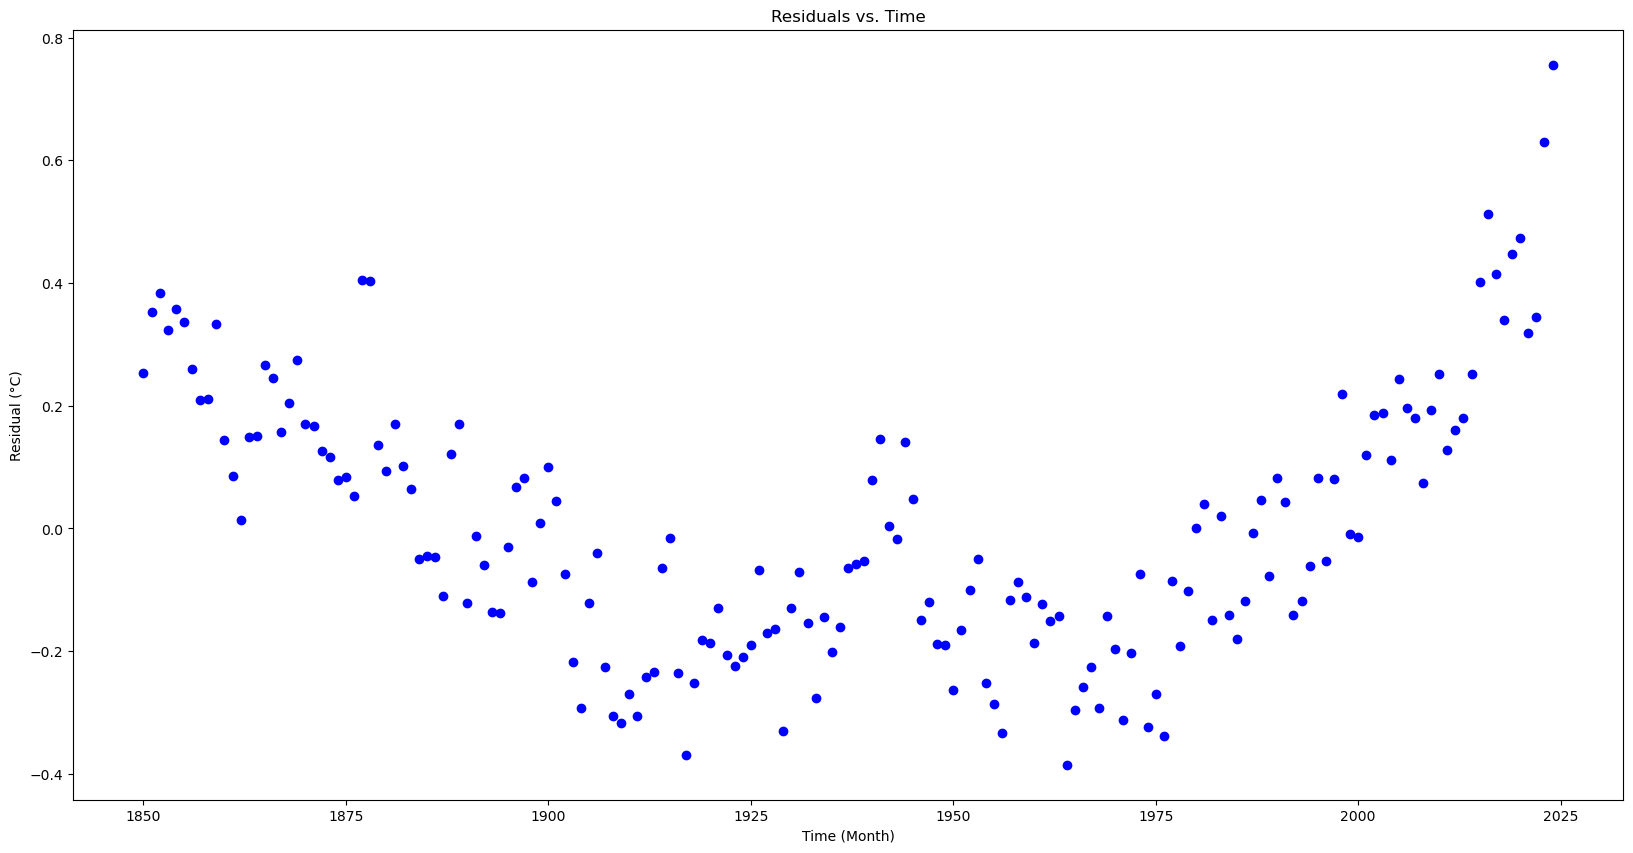

In [44]:
# Plot the residuals
fig,ax=plt.subplots(figsize=(20,10))
ax.scatter(anom_sum2['year'],anom_sum2['anom']-y_pred_uni,color='b')
ax.set_xlabel('Time (Month)')
ax.set_ylabel('Residual (\u00b0C)')
ax.set_title('Residuals vs. Time')
plt.show()

### Our line doesn't seem to be a great fit and there looks to be a pattern in the residuals so lets try doing a Polynomial Regression with a 2nd degree polynomial

In [45]:
# Create a 2nd degree Polynomial Regression
poly = PolynomialFeatures(degree=2)
poly_features = poly.fit_transform(anom_sum2['year'].values.reshape(-1, 1))

mod_poly = sm.OLS(anom_sum2['anom'].to_numpy(),poly_features).fit()

print(mod_poly)
print(mod_poly.summary())

y_pred_poly = mod_poly.fittedvalues

rmse_err_poly = root_mean_squared_error(anom_sum2['anom'].to_numpy(), y_pred_poly)
print('RMSE = ',rmse_err_poly)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     711.5
Date:                Fri, 03 May 2024   Prob (F-statistic):           6.58e-84
Time:                        21:23:08   Log-Likelihood:                 123.47
No. Observations:                 175   AIC:                            -240.9
Df Residuals:                     172   BIC:                            -231.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        284.6704     14.971     19.015      0.0

### Our R-squared is now 0.892 and our RMSE is 0.119 which is much better than our univariate linear regression model and our p value is 0

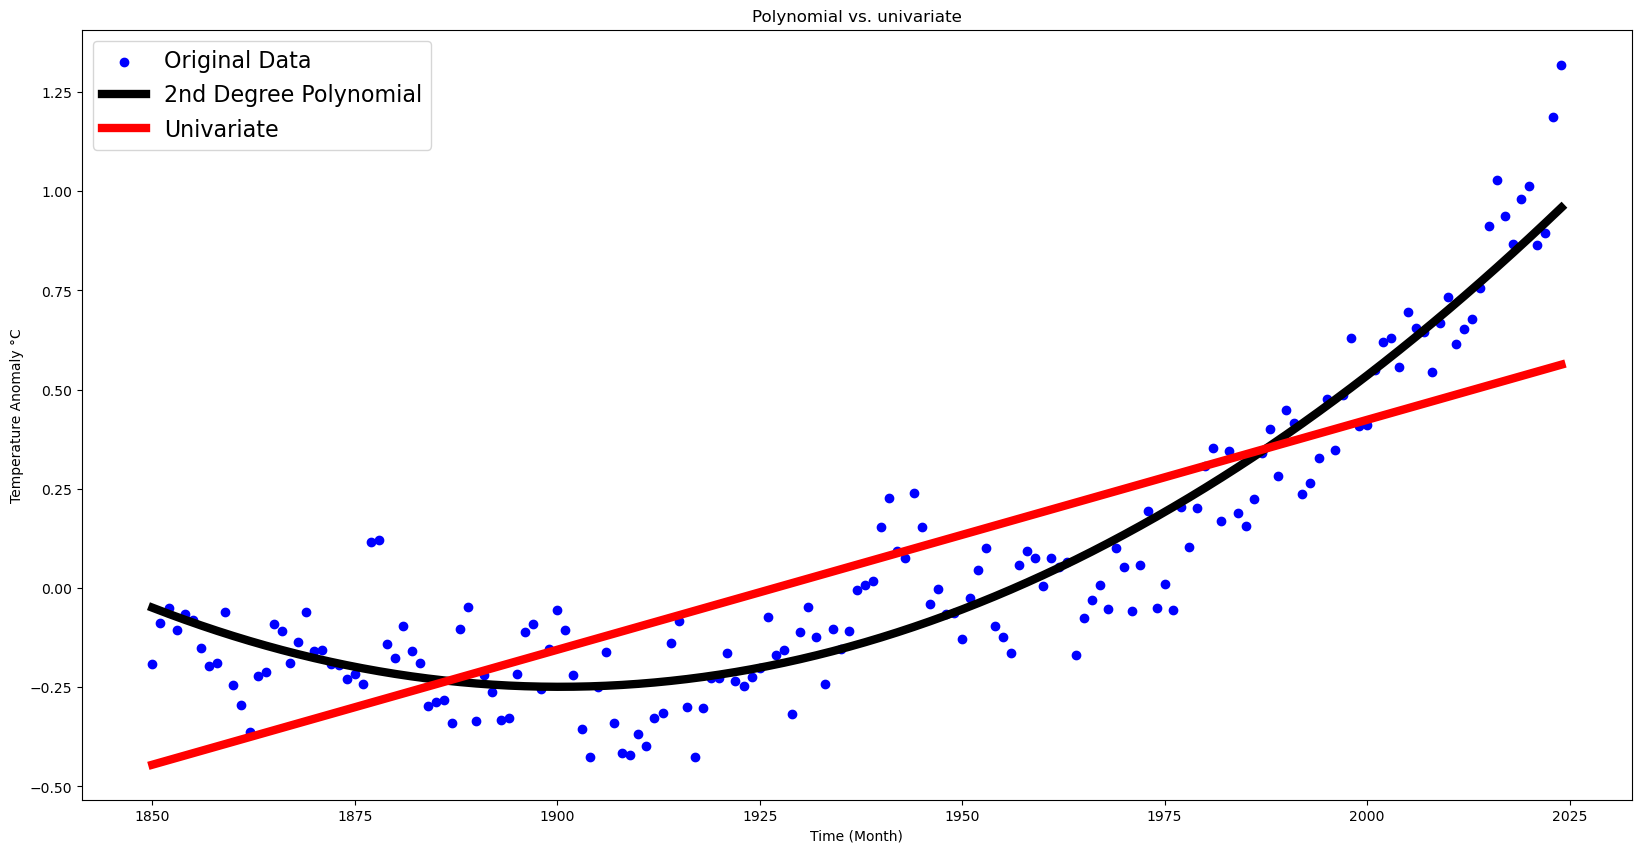

In [46]:
# Plot Polynomial Regression against our Univariate Linear Regression and the orginal data
fig,ax=plt.subplots(figsize=(20,10))
ax.scatter(anom_sum2['year'], anom_sum2['anom'], color='blue', label='Original Data')

ax.set_xlabel('Time (Month)')
ax.set_ylabel('Temperature Anomaly \u00b0C')

            
ax.set_title('Polynomial vs. univariate')
ax.plot(anom_sum2['year'], y_pred_poly, color='black',linewidth=6,label='2nd Degree Polynomial')
ax.plot(anom_sum2['year'], y_pred_uni, color='red',linewidth=6,label='Univariate')

ax.legend(fontsize=16)
plt.show()

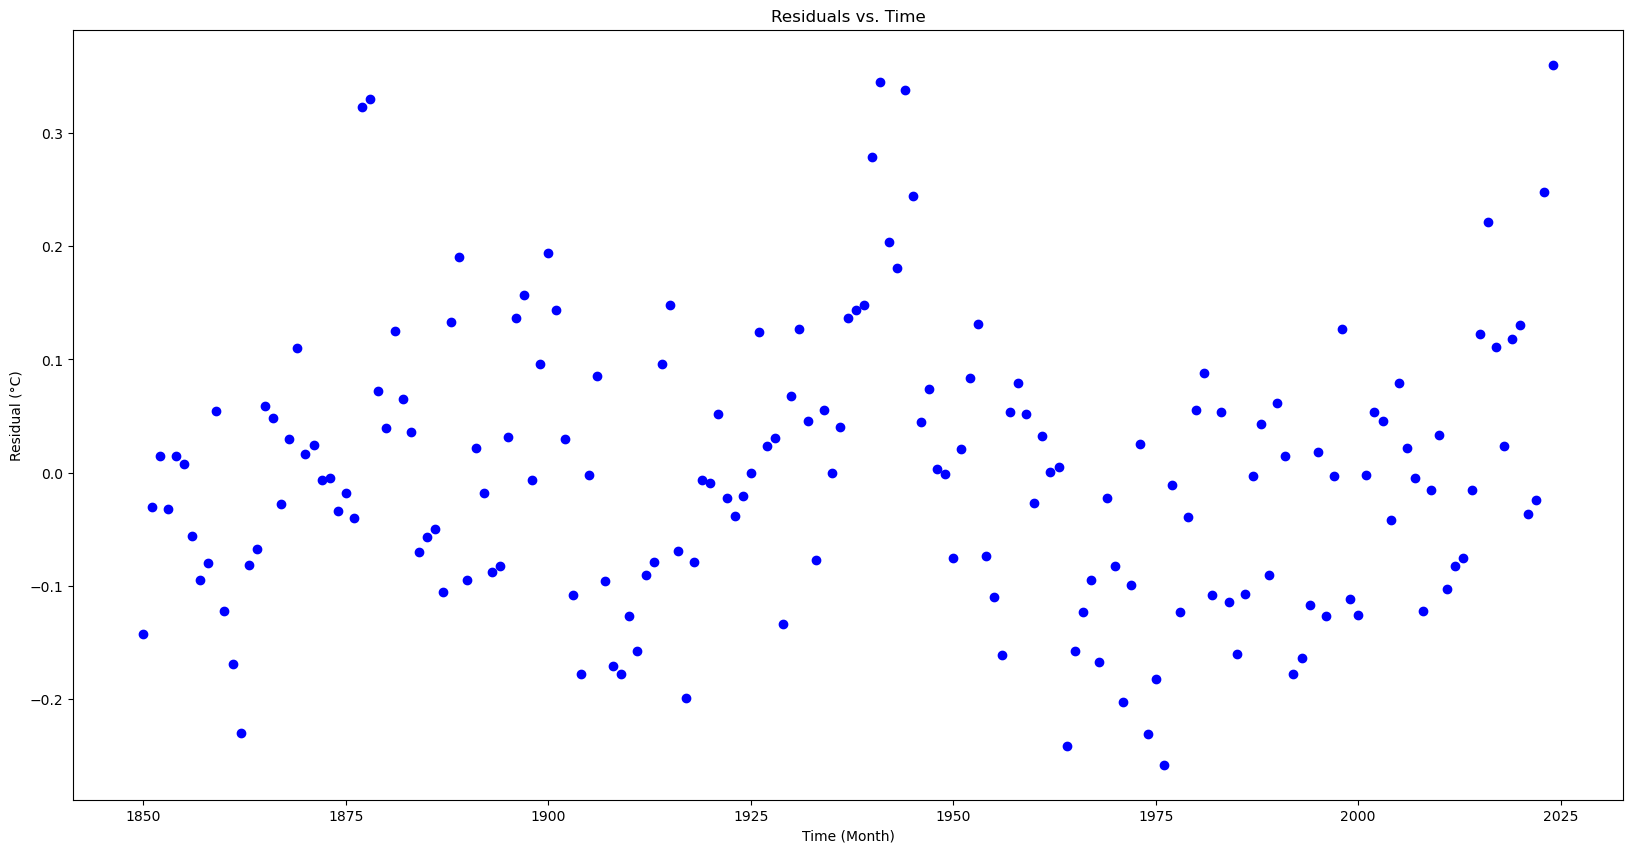

In [47]:
# Plot the residuals
fig,ax=plt.subplots(figsize=(20,10))
ax.scatter(anom_sum2['year'],anom_sum2['anom']-y_pred_poly,color='b')
ax.set_xlabel('Time (Month)')
ax.set_ylabel('Residual (\u00b0C)')
ax.set_title('Residuals vs. Time')
plt.show()

### As we can see our Polynomial Regression performs much better and the residuals are less patterned but there are still problems with serial correlation and other numerical problems according to our different test statistics. With more time a proper time-series analysis could be done.

With more time in the future to work on this project I would like to do a proper time series analysis using techniques that are outside the scope of this class.

Some other ideas I had were observing anomalies over land compared to those over sea to see if there were any significant differences there. Also comparing temperature anomaly data to other datasets like climate change indicators, greenhouse gas emissions, socioeconomic data, climate migration, and more.

Lastly I would like to explore using other machine learning techniques such as neural networks to make predictions with the data.